In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('pennines_sin_grad_le_fil.csv')

In [2]:
# Drop rows where 'sinuosity' or 'm_chi' are missing (no data values)
df = df.dropna(subset=['sinuosity', 'gradient', 'LE'])

In [3]:
# Create 9 quantile bins
df['gradient_bin'] = pd.qcut(df['gradient'], q=9, labels=False)

# Get the bin ranges (intervals) from qcut
bin_ranges = pd.qcut(df['gradient'], q=9).cat.categories

# Create a dictionary to map bin numbers to ranges with 3 decimal places
bin_labels = {i: f"{interval.left:.3f}–{interval.right:.3f}" for i, interval in enumerate(bin_ranges)}

# Calculate midpoints for each bin and store in a dictionary
bin_midpoints = {i: (interval.left + interval.right) / 2 for i, interval in enumerate(bin_ranges)}

# Map the bin numbers to their range labels and midpoints
df['gradient_bin_label'] = df['gradient_bin'].map(bin_labels)
df['gradient_bin_midpoint'] = df['gradient_bin'].map(bin_midpoints)

# Print the 9 gradient bins and their ranges with midpoints to 3 decimal places
print("Gradient Bins and Their Ranges with Midpoints:")
for bin_num, bin_range in bin_labels.items():
    midpoint = bin_midpoints[bin_num]
    print(f"Bin {bin_num}: {bin_range}, Midpoint: {midpoint:.3f}")


Gradient Bins and Their Ranges with Midpoints:
Bin 0: -0.001–0.005, Midpoint: 0.002
Bin 1: 0.005–0.010, Midpoint: 0.007
Bin 2: 0.010–0.014, Midpoint: 0.012
Bin 3: 0.014–0.020, Midpoint: 0.017
Bin 4: 0.020–0.027, Midpoint: 0.024
Bin 5: 0.027–0.036, Midpoint: 0.032
Bin 6: 0.036–0.048, Midpoint: 0.042
Bin 7: 0.048–0.064, Midpoint: 0.056
Bin 8: 0.064–0.205, Midpoint: 0.134


In [4]:
# Count the number of entries in each bin
print(df['gradient_bin'].value_counts().sort_index())


gradient_bin
0    152
1    152
2    151
3    152
4    151
5    152
6    151
7    152
8    152
Name: count, dtype: int64


In [5]:
# Group by bins and calculate mean sinuosity and lithology
grouped = df.groupby('gradient_bin_midpoint')[['sinuosity', 'LE']].mean()
print(grouped)


                       sinuosity        LE
gradient_bin_midpoint                     
0.002130                1.375667  0.583396
0.007455                1.354705  0.573684
0.011775                1.335893  0.564238
0.016900                1.294693  0.569987
0.023500                1.276345  0.576159
0.031750                1.295325  0.565100
0.042200                1.236283  0.562977
0.055800                1.219299  0.557143
0.134300                1.219034  0.556516


In [32]:
# Save the binned dataset
df.to_csv('pennines_binned_grad_9.csv', index=False)


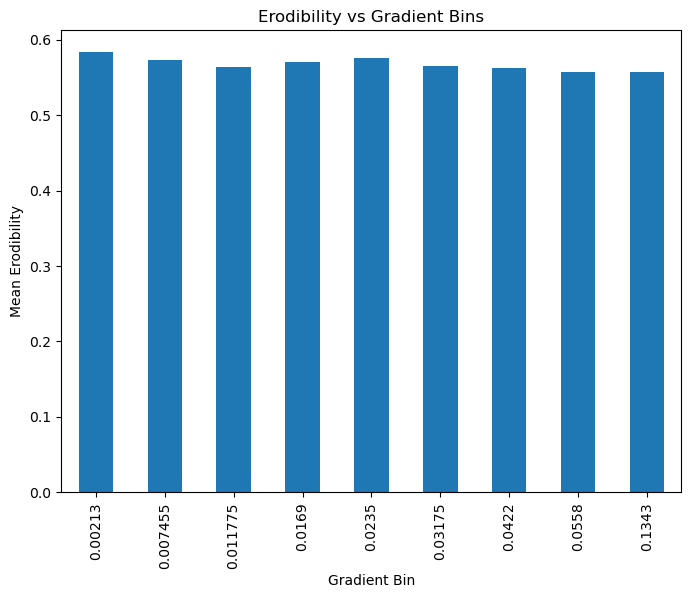

In [7]:
grouped['LE'].plot(kind='bar', figsize=(8, 6))
plt.xlabel('Gradient Bin')
plt.ylabel('Mean Erodibility')
plt.title('Erodibility vs Gradient Bins')
plt.show()


Box Plot Data Lengths (per Bin):
Bin 0: 152 values
Bin 1: 152 values
Bin 2: 151 values
Bin 3: 152 values
Bin 4: 151 values
Bin 5: 152 values
Bin 6: 151 values
Bin 7: 152 values
Bin 8: 152 values


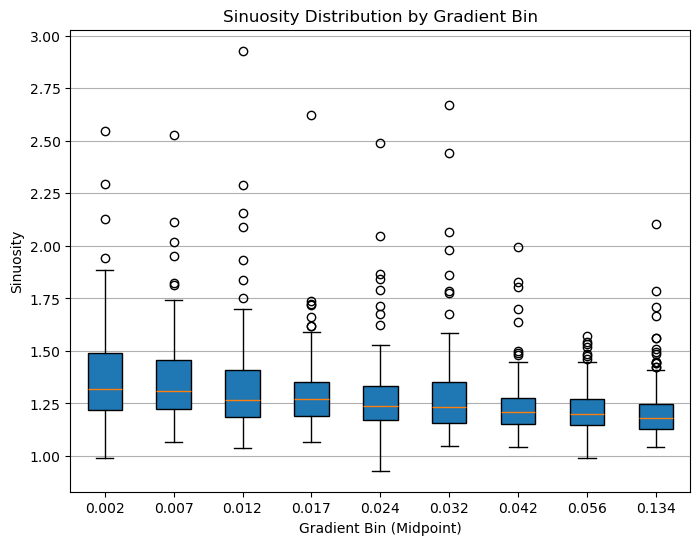

In [34]:
import matplotlib.pyplot as plt

# Prepare data for the box plot
boxplot_data = [
    df[df['gradient_bin'] == bin_number]['sinuosity']
    for bin_number in sorted(df['gradient_bin'].unique())
]

# Get the midpoints for each bin
bin_midpoints = df.groupby('gradient_bin')['gradient_bin_midpoint'].first().sort_index().values

# Debugging: Check that boxplot_data is populated correctly
print("\nBox Plot Data Lengths (per Bin):")
for i, data in enumerate(boxplot_data):
    print(f"Bin {i}: {len(data)} values")

# Create the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(boxplot_data, labels=[f"{midpoint:.3f}" for midpoint in bin_midpoints], patch_artist=True)
plt.xlabel('Gradient Bin (Midpoint)')
plt.ylabel('Sinuosity')
plt.title('Sinuosity Distribution by Gradient Bin')
plt.grid(axis='y')

plt.show()


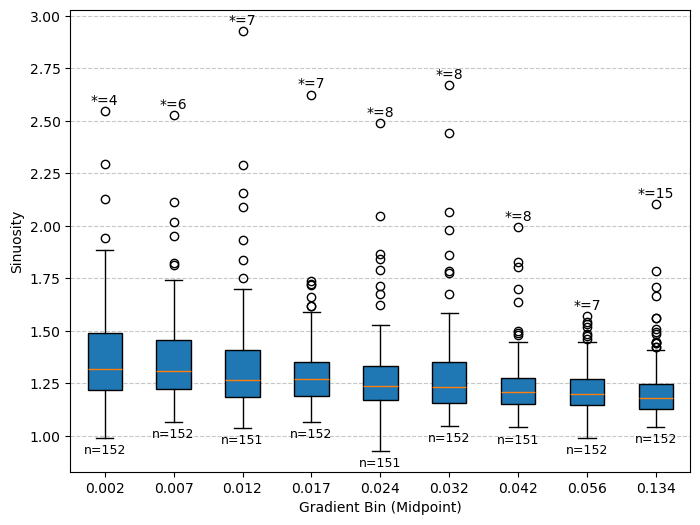

In [7]:
import matplotlib.pyplot as plt

# Prepare data for the box plot
boxplot_data = [
    df[df['gradient_bin'] == bin_number]['sinuosity']
    for bin_number in sorted(df['gradient_bin'].unique())
]

# Get the midpoints for each bin
bin_midpoints = df.groupby('gradient_bin')['gradient_bin_midpoint'].first().sort_index().values

# Get number of points per bin
n_values = [len(data) for data in boxplot_data]

# Create the box plot
plt.figure(figsize=(8, 6))
box = plt.boxplot(boxplot_data, labels=[f"{midpoint:.3f}" for midpoint in bin_midpoints], patch_artist=True)

# Loop through each bin to annotate n-values and outliers
for i, (n, data) in enumerate(zip(n_values, boxplot_data), start=1):
    y_min = min(data) if len(data) > 0 else 0  # Min value for placing n=
    y_max = max(data) if len(data) > 0 else 0  # Max value for placing outlier count

    # Get number of outliers from the fliers data
    num_outliers = len(box["fliers"][i-1].get_ydata())

    # Annotate total points below
    plt.text(i, y_min - 0.075, f"n={n}", ha='center', fontsize=9, color='black')

    # Annotate outliers above
    if num_outliers > 0:  # Only annotate if there are outliers
        plt.text(i, y_max + 0.03, f"*={num_outliers}", ha='center', fontsize=10, color='black')

plt.xlabel('Gradient Bin (Midpoint)')
plt.ylabel('Sinuosity')
plt.grid(axis='y', linestyle="--", alpha=0.7)

plt.show()

In [35]:
import pandas as pd
import numpy as np
from collections import Counter

# Initialize dictionaries to store results
outlier_counts = {i: Counter() for i in range(9)}  # For LE outlier counts
outlier_stats = {}  # For storing the number and percentage of outliers in each bin

# Loop through each gradient_bin
for i in range(9):  # Update the range to include bins 0 to 8
    # Filter data for the current bin
    bin_data = df[df['gradient_bin'] == i]
    
    # Extract sinuosity and LE values for this bin
    sin_data = bin_data['sinuosity']
    le_data = bin_data['LE']
    
    # Calculate the outlier thresholds for sinuosity
    q1 = np.percentile(sin_data, 25)
    q3 = np.percentile(sin_data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Identify outliers based on the thresholds
    outliers = sin_data[(sin_data < lower_bound) | (sin_data > upper_bound)]
    outlier_indices = outliers.index  # Indices of the outliers
    
    # Get corresponding LE values for the outliers
    outlier_LE = le_data.loc[outlier_indices]
    
    # Count the frequency of each LE value and update the Counter
    outlier_counts[i].update(outlier_LE)
    
    # Calculate number of outliers and percentage
    total_points_in_bin = len(bin_data)
    num_outliers = len(outliers)
    percentage_outliers = (num_outliers / total_points_in_bin) * 100 if total_points_in_bin > 0 else 0
    
    # Store stats for the current bin
    outlier_stats[i] = {
        'total_points': total_points_in_bin,
        'num_outliers': num_outliers,
        'percent_outliers': percentage_outliers
    }

# Convert the tally dictionary into a DataFrame
outlier_table = pd.DataFrame.from_dict(outlier_counts, orient='index').fillna(0)

# Convert the stats dictionary into a DataFrame
stats_table = pd.DataFrame.from_dict(outlier_stats, orient='index')

# Display the tables
print("Tally of Outlier LE Values by Gradient Bin:")
print(outlier_table)

print("\nOutlier Statistics by Gradient Bin:")
print(stats_table)

Tally of Outlier LE Values by Gradient Bin:
   0.638095  0.552381  0.619048  0.628571  0.695238  0.285714
0       1.0         2       1.0       0.0       0.0       0.0
4       2.0         5       0.0       0.0       1.0       0.0
1       0.0         5       1.0       0.0       0.0       0.0
2       0.0         5       2.0       0.0       0.0       0.0
3       0.0         5       0.0       1.0       1.0       0.0
5       0.0         5       3.0       0.0       0.0       0.0
6       0.0         7       0.0       0.0       1.0       0.0
7       0.0         6       0.0       1.0       0.0       0.0
8       0.0         9       2.0       3.0       0.0       1.0

Outlier Statistics by Gradient Bin:
   total_points  num_outliers  percent_outliers
0           152             4          2.631579
1           152             6          3.947368
2           151             7          4.635762
3           152             7          4.605263
4           151             8          5.298013
5          